# Elliptic Curve Cryptography Explained


Elliptic Curve Cryptography (ECC) is a form of public‑key cryptography built on the algebra of **points on an elliptic curve** over a finite field.

- Curve: \( y^2 = x^3 + ax + b \) over \( \mathbb{F}_p \)
- Points form an abelian group; we can add them, double them, and do scalar multiplication \(kG\)
- Private key \(k\), public key \(K = kG\); hard to reverse (ECDLP)

This notebook includes visualizations, toy curve operations, and an ECDH demo.


## Curve Shape over the Reals

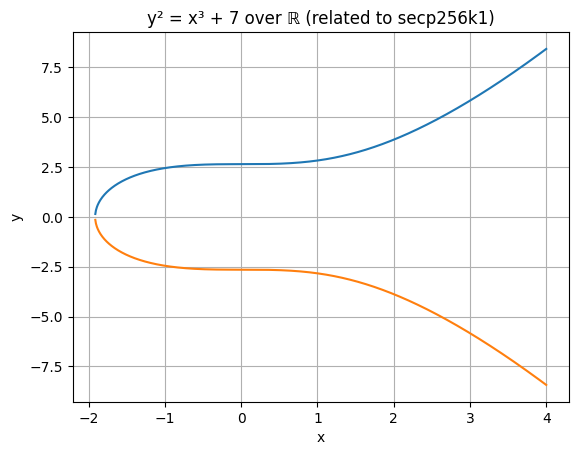

In [1]:

import numpy as np
import matplotlib.pyplot as plt

a, b = 0.0, 7.0
xs = np.linspace(-4, 4, 2000)
ysq = xs**3 + a*xs + b
mask = ysq >= 0
ys = np.sqrt(ysq[mask])

plt.plot(xs[mask], ys)
plt.plot(xs[mask], -ys)
plt.title("y² = x³ + 7 over ℝ (related to secp256k1)")
plt.xlabel("x"); plt.ylabel("y")
plt.grid()
plt.show()


## Toy Finite Field Curve: Point Addition, Doubling, Scalar Multiplication

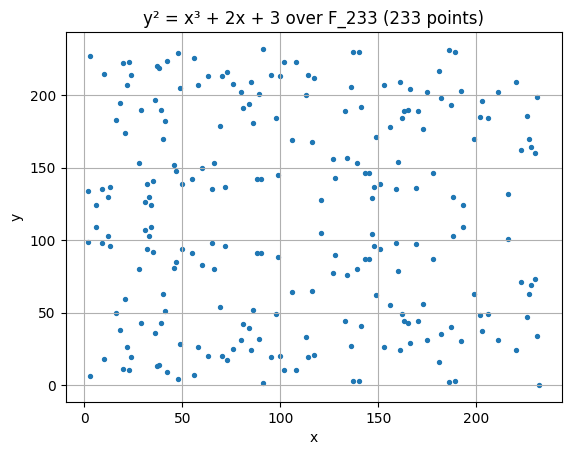

In [2]:

p, a, b = 233, 2, 3
def inv_mod(x, p): return pow(x % p, p-2, p)
def is_on_curve(P):
    if P is None: return True
    x, y = P
    return (y*y - (x*x*x + a*x + b)) % p == 0

O = None
def point_add(P, Q):
    if P is None: return Q
    if Q is None: return P
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and (y1 + y2) % p == 0: return O
    if P != Q:
        lam = ((y2 - y1) * inv_mod((x2 - x1) % p, p)) % p
    else:
        if y1 % p == 0: return O
        lam = ((3 * x1*x1 + a) * inv_mod((2*y1) % p, p)) % p
    x3 = (lam*lam - x1 - x2) % p
    y3 = (lam*(x1 - x3) - y1) % p
    return (x3, y3)
def scalar_mult(k, P):
    R = O
    N = P
    while k > 0:
        if k & 1:
            R = point_add(R, N)
        N = point_add(N, N)
        k >>= 1
    return R

# Points on the curve
points = []
for x in range(p):
    rhs = (x**3 + a*x + b) % p
    for y in range(p):
        if (y*y) % p == rhs:
            points.append((x, y))

plt.scatter(*zip(*points), s=8)
plt.title(f"y² = x³ + {a}x + {b} over F_{p} ({len(points)} points)")
plt.xlabel("x"); plt.ylabel("y")
plt.grid()
plt.show()


## Visualizing Scalar Multiples of a Point G

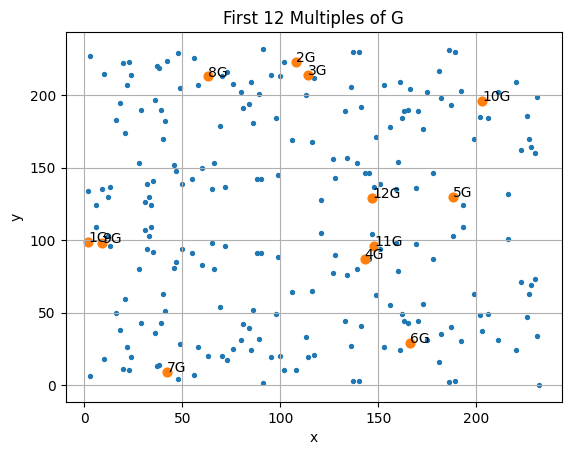

In [3]:

G = points[0]
trail = [scalar_mult(k, G) for k in range(1, 13)]
plt.scatter(*zip(*points), s=8)
plt.scatter(*zip(*trail), s=40)
for i, (x, y) in enumerate(trail): plt.annotate(f"{i+1}G", (x, y))
plt.title("First 12 Multiples of G")
plt.xlabel("x"); plt.ylabel("y")
plt.grid()
plt.show()


## ECDH Key Agreement on secp256k1

In [4]:

from ecdsa import SigningKey, SECP256k1

a_sk = SigningKey.generate(curve=SECP256k1)
a_vk = a_sk.get_verifying_key()
b_sk = SigningKey.generate(curve=SECP256k1)
b_vk = b_sk.get_verifying_key()
a = a_sk.privkey.secret_multiplier
b = b_sk.privkey.secret_multiplier
Pa = a_vk.pubkey.point
Pb = b_vk.pubkey.point
S1 = Pb * a
S2 = Pa * b
shared1 = S1.x().to_bytes((S1.x().bit_length() + 7) // 8, "big")
shared2 = S2.x().to_bytes((S2.x().bit_length() + 7) // 8, "big")
print("ECDH shared secrets match?", shared1 == shared2)
print("Shared secret (hex):", shared1.hex())


ECDH shared secrets match? True
Shared secret (hex): b4dee942c2ea848290126f1ca13ecf7c6d87dbeeb6b66c77b59782919be42253


## Summary


Elliptic Curve Cryptography powers modern blockchains due to its compact keys, strong security, and efficient operations. We explored:

- Visual shape and curve algebra (add, double)
- Scalar multiplication with double-and-add
- Finite field toy curves and real curve (secp256k1)
- ECDH key exchange producing equal shared secrets

Avoid nonce reuse in ECDSA, and use tested libraries for production use of ECC.


## ECDSA Nonce‑Reuse Attack (Mini‑Demo)


If an ECDSA signer reuses the **same nonce `k`** to sign two different messages, an attacker who sees both signatures can recover the private key.

Let the two messages be hashed to integers `z1` and `z2`, and the signatures be `(r, s1)` and `(r, s2)` (note **same `r`** because the same `k` was used). Over the curve order `n`:

1. Recover the nonce:
\[
k \equiv (z_1 - z_2) \cdot (s_1 - s_2)^{-1} \pmod{n}
\]

2. Recover the private key:
\[
d \equiv (s_1 \cdot k - z_1) \cdot r^{-1} \pmod{n}
\]

Below we simulate this on **secp256k1**, generate two signatures with the same `k`, and recover the private key. *Lesson:* **Never** reuse ECDSA nonces; use deterministic signing or a CSPRNG.


In [5]:

import hashlib
from ecdsa.ecdsa import generator_secp256k1, curve_secp256k1, Public_key, Private_key, Signature
from ecdsa.numbertheory import inverse_mod
import secrets

G = generator_secp256k1
n = G.order()

def H(msg: bytes) -> int:
    return int.from_bytes(hashlib.sha256(msg).digest(), "big") % n

d = secrets.randbelow(n - 1) + 1
Q = Public_key(G, d * G)
priv = Private_key(Q, d)

k = secrets.randbelow(n - 1) + 1
m1 = b"transaction A: pay alice 1 BTC"
m2 = b"transaction B: pay bob 2 BTC"
z1, z2 = H(m1), H(m2)

def ecdsa_sign_with_k(priv: Private_key, z: int, k: int):
    R = k * G
    r = R.x() % n
    s = (inverse_mod(k, n) * (z + priv.secret_multiplier * r)) % n
    return Signature(r, s)

sig1 = ecdsa_sign_with_k(priv, z1, k)
sig2 = ecdsa_sign_with_k(priv, z2, k)
assert sig1.r == sig2.r, "Reused k implies same r!"

print("Original private key d:", hex(d))
print("Signatures (r, s1), (r, s2):")
print(" r =", hex(sig1.r))
print(" s1=", hex(sig1.s))
print(" s2=", hex(sig2.s))

k_recovered = ((z1 - z2) * inverse_mod((sig1.s - sig2.s) % n, n)) % n
d_recovered = (((sig1.s * k_recovered - z1) % n) * inverse_mod(sig1.r, n)) % n

print("\nRecovered k     =", hex(k_recovered))
print("Recovered d     =", hex(d_recovered))
print("Keys match?     =", d_recovered == d)


Original private key d: 0xd9d7c6c2ac0b1db1bba4f0985671591af14ba085f4a519e7d675f7f863047535
Signatures (r, s1), (r, s2):
 r = 0x51d9994f0394b9b0efd2b023c1b1a9bab22580035f0da0a14aa41dcadfd2c88c
 s1= 0xdcffe585a322aed6e6dd37d4a267112e79793c7097caa7ed42d93a84fc1ec358
 s2= 0x9fe3a092b7dd3c203ec9f9994eb8c7833cacb09f98bc968dab08094bd0d496ff

Recovered k     = 0x9c51a8db6d0db7d44fb6c850642432a4f66a6df42161a99323feef36ff554cd7
Recovered d     = 0xd9d7c6c2ac0b1db1bba4f0985671591af14ba085f4a519e7d675f7f863047535
Keys match?     = True


## Double‑and‑Add: Step‑by‑Step Visualization (Toy Curve)


Scalar multiplication \(k \cdot G\) on an elliptic curve uses the **double‑and‑add** method:
- Read bits of \(k\) from **MSB → LSB**
- Start with \(R = \mathcal{O}\) (point at infinity)
- For each bit: double and conditionally add

This animation shows the accumulation of multiples on a toy curve.


In [6]:

import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

def inv_mod(x, p): return pow(x % p, p - 2, p)
O = None
def point_add(P, Q):
    if P is None: return Q
    if Q is None: return P
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and (y1 + y2) % p == 0: return O
    if P != Q:
        lam = ((y2 - y1) * inv_mod((x2 - x1) % p, p)) % p
    else:
        if y1 % p == 0: return O
        lam = ((3 * x1*x1 + a) * inv_mod((2*y1) % p, p)) % p
    x3 = (lam*lam - x1 - x2) % p
    y3 = (lam*(x1 - x3) - y1) % p
    return (x3, y3)

# Parameters
p, a, b = 233, 2, 3
points = []
for x in range(p):
    rhs = (x*x*x + a*x + b) % p
    for y in range(p):
        if (y*y) % p == rhs:
            points.append((x, y))

def scalar_mult(k, P):
    R = O
    N = P
    while k > 0:
        if k & 1:
            R = point_add(R, N)
        N = point_add(N, N)
        k >>= 1
    return R

G = points[0]
k_demo = 173
bits = bin(k_demo)[2:]
R = O

for i, bit in enumerate(bits):
    R = point_add(R, R)
    if bit == '1':
        R = point_add(R, G)

    clear_output(wait=True)
    plt.figure()
    plt.scatter([x for x, y in points], [y for x, y in points], s=8)
    if R is not None:
        plt.scatter([R[0]], [R[1]], s=80)
        plt.annotate("R", (R[0], R[1]))
    plt.title(f"Double-and-Add Step {i+1}/{len(bits)} — bit={bit}, k={k_demo}")
    plt.xlabel("x mod p"); plt.ylabel("y mod p")
    plt.grid()
    plt.show()
    time.sleep(0.8)

R_final = scalar_mult(k_demo, G)
print("k*G via double-and-add (final R):", R)
print("k*G via direct scalar_mult:      ", R_final)
print("Match?", R == R_final)


k*G via double-and-add (final R): (121, 128)
k*G via direct scalar_mult:       (121, 128)
Match? True



## ECDSA Nonce‑Reuse Attack (Mini‑Demo)

If an ECDSA signer reuses the **same nonce `k`** to sign two different messages, an attacker who sees both signatures can recover the private key.

Let the two messages be hashed to integers `z1` and `z2`, and the signatures be `(r, s1)` and `(r, s2)` (note **same `r`** because the same `k` was used). Over the curve order `n`:

1. Recover the nonce:
\[
k \equiv (z_1 - z_2) \cdot (s_1 - s_2)^{-1} \pmod{n}
\]

2. Recover the private key:
\[
d \equiv (s_1 \cdot k - z_1) \cdot r^{-1} \pmod{n}
\]

Below we simulate this on **secp256k1**, generate two signatures with the same `k`, and recover the private key. *Lesson:* **Never** reuse ECDSA nonces; use deterministic signing or a CSPRNG.


In [7]:

# ECDSA nonce-reuse key recovery on secp256k1 (educational demo)
import hashlib
from ecdsa.ecdsa import generator_secp256k1, Public_key, Private_key, Signature
from ecdsa.numbertheory import inverse_mod
import secrets

G = generator_secp256k1
n = G.order()

def H(msg: bytes) -> int:
    # Integer hash per ECDSA spec (use SHA-256 here)
    return int.from_bytes(hashlib.sha256(msg).digest(), "big") % n

# --- Generate a random private key d and its public key Q = d*G ---
d = secrets.randbelow(n - 1) + 1
Q = Public_key(G, d * G)
priv = Private_key(Q, d)

# --- BAD: choose a single nonce k and reuse it for two messages ---
k = secrets.randbelow(n - 1) + 1
m1 = b"transaction A: pay alice 1 BTC"
m2 = b"transaction B: pay bob 2 BTC"
z1, z2 = H(m1), H(m2)

# ECDSA signature with explicit k using the low-level API
def ecdsa_sign_with_k(priv: Private_key, z: int, k: int):
    R = k * G
    r = R.x() % n
    s = (inverse_mod(k, n) * (z + priv.secret_multiplier * r)) % n
    return Signature(r, s)

sig1 = ecdsa_sign_with_k(priv, z1, k)
sig2 = ecdsa_sign_with_k(priv, z2, k)
assert sig1.r == sig2.r, "Reused k implies same r!"

print("Original private key d:", hex(d))
print("Signatures (r, s1), (r, s2):")
print(" r =", hex(sig1.r))
print(" s1=", hex(sig1.s))
print(" s2=", hex(sig2.s))

# --- Attacker recovers k and then d from two signatures sharing r ---
k_recovered = ((z1 - z2) * inverse_mod((sig1.s - sig2.s) % n, n)) % n
d_recovered = (((sig1.s * k_recovered - z1) % n) * inverse_mod(sig1.r, n)) % n

print("\nRecovered k     =", hex(k_recovered))
print("Recovered d     =", hex(d_recovered))
print("Keys match?     =", d_recovered == d)


Original private key d: 0x5ff324bf54842c27c45cbfdb3c7c494d152876aeb624ac2de18779031fc1fe40
Signatures (r, s1), (r, s2):
 r = 0x2f6d975d11e7c3c804959eef6399f662d8079f6fa0ce5d37134b034adec23841
 s1= 0xa3f8d14b50aebb3927c3c3ddcd1bf2de4803a8e28e46999bc187b232573813a5
 s2= 0x8f5b47d73a3b00d8c08b8ef6586292fdfd5f38e1a459ad4d8472fb6082d08e93

Recovered k     = 0x9513e0d65545e81dfd71cf99593efcf9cad6ab621c5dae2e2b7c1ef7ed05185
Recovered d     = 0x5ff324bf54842c27c45cbfdb3c7c494d152876aeb624ac2de18779031fc1fe40
Keys match?     = True



## Double‑and‑Add: Step‑by‑Step Visualization (Toy Curve)

Scalar multiplication \(k\cdot G\) on an elliptic curve uses the **double‑and‑add** method:
- Read bits of \(k\) from **MSB → LSB**.
- Start with \(R = \mathcal{O}\) (point at infinity).
- For each bit: **double** \(R\); if the bit is 1, **add** \(G\).

We use a **small toy curve over a prime field** so we can plot points and update a simple animation inline. This is for *intuition*; real curves use 256‑bit primes.


In [8]:

# Double-and-add visualization on a toy curve over F_p.
# This runs inline in Jupyter and uses simple frame updates with clear_output.
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

# ---- Toy curve: y^2 = x^3 + a*x + b over F_p ----
p = 233
a = 2
b = 3

def inv_mod(x, p):
    return pow(x % p, p - 2, p)

O = None

def is_on_curve(P):
    if P is None: return True
    x, y = P
    return (y*y - (x*x*x + a*x + b)) % p == 0

def point_add(P, Q):
    if P is None: return Q
    if Q is None: return P
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and (y1 + y2) % p == 0:
        return O
    if P != Q:
        lam = ((y2 - y1) * inv_mod((x2 - x1) % p, p)) % p
    else:
        if y1 % p == 0: return O
        lam = ((3 * x1*x1 + a) * inv_mod((2*y1) % p, p)) % p
    x3 = (lam*lam - x1 - x2) % p
    y3 = (lam*(x1 - x3) - y1) % p
    return (x3, y3)

def scalar_mult(k, P):
    R = O
    N = P
    while k > 0:
        if k & 1:
            R = point_add(R, N)
        N = point_add(N, N)
        k >>= 1
    return R

# Enumerate all points for background scatter
points = []
for x in range(p):
    rhs = (x*x*x + a*x + b) % p
    for y in range(p):
        if (y*y) % p == rhs:
            points.append((x, y))

# Choose a point G that lies on the curve
G = points[0]
assert is_on_curve(G)

# Parameters for the demo
k_demo = 173  # any positive integer < p works here for the demo
bits = bin(k_demo)[2:]  # MSB->LSB

# Simple "animation": update plot frame by frame
R = O
for i, bit in enumerate(bits):
    # double
    R = point_add(R, R) if R is not None else O
    # add if bit is 1
    if bit == "1":
        R = point_add(R, G) if R is not None else G

    # Draw current frame
    clear_output(wait=True)
    plt.figure()
    plt.scatter([x for x, y in points], [y for x, y in points], s=8)
    if R is not None:
        plt.scatter([R[0]], [R[1]], s=80)
        plt.annotate(f"R (step {i+1}/{len(bits)}; bit={bit})", (R[0], R[1]))
    plt.title(f"Double-and-Add (MSB→LSB) — k={k_demo} (bin {bits})")
    plt.xlabel("x mod p"); plt.ylabel("y mod p")
    plt.show()
    time.sleep(0.8)

# Final check vs direct multiplication
R_final = scalar_mult(k_demo, G)
print("R after loop:", R)
print("k*G via direct scalar_mult:", R_final)
print("Match?", R == R_final)


R after loop: (121, 128)
k*G via direct scalar_mult: (121, 128)
Match? True
